# Masked Autoregressive Flows (MAFs)

In [1]:
%load_ext autoreload

%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable

import torch
import torch.utils.data as data

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

2024-02-14 15:21:31.989323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 15:21:31.989430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 15:21:32.017143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 15:21:39.080369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Testing Masked Linear layer

In [2]:
from normflow.model import MaskedLinear

model = MaskedLinear(3)
input = jnp.arange(5)
mask = jnp.zeros((5, 3))
model.initialize_mask(mask)

params = model.init(jax.random.PRNGKey(0), input)

2024-02-14 15:22:50.901484: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
model.apply(params, input)

Array([0., 0., 0.], dtype=float64)

In [4]:
mask = jnp.ones((5, 3))
model.initialize_mask(mask)
print(mask)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [5]:
model.apply(params, input)

Array([ 1.6449495 ,  0.90466896, -4.55038121], dtype=float64)

In [6]:
from normflow.model import ConditionalMADE

In [7]:
model = ConditionalMADE(3, [5, 5], n_cond=3, gaussian=True, random_order=True, seed=36)

In [8]:
params = model.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [9]:
input = jnp.array([0.5, 0.5, 0.5])
cond = jnp.array([1, 1, 1])
result = model.apply(params, input, cond) 

In [10]:
result

Array([ 0.1636737 ,  0.        , -0.02277961,  0.26304815,  0.        ,
       -0.04986678], dtype=float64)

### Testing MAF Layer

In [170]:
from normflow.model import MAFLayer

In [171]:
maf_layer = MAFLayer(3, 3, [5, 5], reverse=False, seed=100)

In [172]:
params = maf_layer.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [173]:
input = jnp.arange(3)
cond = jnp.zeros(3)

maf_layer.apply(params, input, cond)

Array([ 0.        ,  0.        , -0.00258242,  0.        ,  0.        ,
        0.01258937], dtype=float64)

In [174]:
u, log_det = maf_layer.apply(params, input, cond, method="forward")
u, log_det

(Array([0.       , 1.       , 2.0152278], dtype=float64),
 Array(0.00629468, dtype=float64))

In [175]:
maf_layer.apply(params, u.reshape(1, 3), cond.reshape(1, 3), method="backward")

(Array([[0., 1., 2.]], dtype=float64), Array([-0.00629468], dtype=float64))

### Testing MAF

In [38]:
from normflow.model import ConditionalMAF

In [40]:
maf = ConditionalMAF(3, 3, 2, [128, 128], use_reverse=False, seed=42)

In [41]:
input = jnp.arange(9).reshape((3,3))
cond = jnp.zeros((3,3))
train = True
variables  = maf.init(jax.random.PRNGKey(0), input, cond, train=True)

In [264]:
from flax.training import train_state
from typing import Any

class TrainState(train_state.TrainState):
    batch_stats: Any

state = TrainState.create(
    apply_fn=maf.apply,
    params=variables["params"],
    batch_stats=variables["batch_stats"],
    tx=optax.adam(1e-3)
)

In [265]:
def train_step(state: TrainState, input, cond):
    def loss_fn(params):
        output, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            input, cond, train=True, mutable=['batch_stats'], method='log_prob'
        )
        print('Output:', output)
        loss = -jnp.mean(output)
        print('Loss:', loss)
        return loss, updates
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    print('Gradient:', grads)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    return state, loss


In [268]:
state, loss = train_step(state, input, cond)

Traced<ConcreteArray([[-8.35887516e-19 -2.18938446e-03  1.84219935e-02]
 [-8.35887516e-19  1.03311201e-01  1.99571382e-01]
 [-8.35887516e-19  6.06362364e-02  3.60363725e-01]], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array([[-8.35887516e-19, -2.18938446e-03,  1.84219935e-02],
       [-8.35887516e-19,  1.03311201e-01,  1.99571382e-01],
       [-8.35887516e-19,  6.06362364e-02,  3.60363725e-01]],      dtype=float64)
  tangent = Traced<ShapedArray(float64[3,3])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[3,3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ffa29acf510>, in_tracers=(Traced<ShapedArray(float64[3,6]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7fffe0a7dc10; to 'JaxprTracer' at 0x7fffe0a7e7f0>], out_avals=[ShapedArray(float64[3,3])], primitive=slice, params={'start_indices': (0, 0), 'limit_indices': (3, 3), 'strides': None}, effects=frozenset(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback o

## Simulation model

In [176]:
sbibm.get_available_tasks()

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'two_moons',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [177]:
task = sbibm.get_task('two_moons')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
dim_cond = observation.shape[1]

print(dim, dim_cond)

2 2


In [178]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.thetas = prior(num_samples=num_samples)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, index):
        return self.thetas[index], self.xs[index]

In [179]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 2000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Neural posterior estimation using MAFs

In [180]:
from normflow.model import ConditionalMAF

In [181]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_data : int,
                 n_cond : int,
                 n_layers : int,
                 hidden_dims : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_data,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'hidden_dims': hidden_dims,
                             'use_reverse': use_reverse,
                             'seed': seed
                         },
                         
                         **kwargs)
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
        
    def print_tabulate(self, exmp_input):
        pass


In [182]:
CHECKPOINT_PATH = '~/work/jax/notebooks/checkpoints/'

trainer = MAFTrainer(
    n_data=dim,
    n_cond=dim_cond,
    n_layers=5,
    hidden_dims=[128, 128],
    optimizer_hparams={'lr': 4e-3},
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    debug=False,
    use_reverse=True
)

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [183]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [184]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.544481115571212
Validation loss: -3.567558592556776
Test loss: -3.5508963421709843


In [185]:
model = trainer.bind_model()

In [186]:
key = jax.random.PRNGKey(42)

samples = model.apply({'params': trainer.state.params}, observation*jnp.ones((10000, 1)), num_samples=10000, key=key, method='sample')

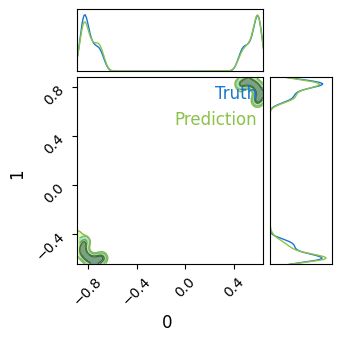

In [187]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
#c.add_chain(jax.random.multivariate_normal(key, jnp.zeros(2), jnp.eye(2), (10000,)), shade_alpha = 0.5, name="Prior")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [188]:
samples_image, _ = model.apply({'params': trainer.state.params}, reference_samples, observation*jnp.ones((10000, 1)), train=False)

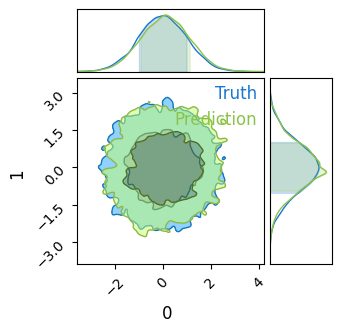

In [189]:
c = ChainConsumer()
c.add_chain(jax.random.multivariate_normal(key, jnp.zeros(2), jnp.eye(2), (10000,)), shade_alpha = 0.5, name='Truth')
c.add_chain(samples_image, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()